# Conducting a Simple Black-box Adversarial Attack on BNN

Adversarial examples are inputs to machine learning models that an attacker has intentionally designed to cause the model to make a mistake; they’re like optical illusions for machines. 

Deep neural networks have been widely used recently. Due to the complexity of current networks, the principles of deep networks remain to be black-box. 

## 1. Import BNN
Import BNN package and check its parameters.
By default the printed trained parameters are available for CNV network using 1 bit for weights and activation model.

PS: I am using usb cable to connect my Ultra board to computer, if you prefer to use wifi mode you need to follow the steps in /common/wifi.ipynb to connect to your wifi first.

In [68]:
import bnn

print(bnn.available_params(bnn.NETWORK_CNVW1A1))

['streetview', 'road-signs', 'cifar10']


## 2. Instantiate a Classifier

Creating a classifier will automatically download the correct bitstream onto device and load the weights trained on the specified dataset. Passing a runtime attribute will allow to choose between hardware accelerated or pure software inference.

Use `CnvClassifier(network,parameters,runtime)` for CNV network topology:

In [69]:
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1,'cifar10',bnn.RUNTIME_HW)
sw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1,'cifar10',bnn.RUNTIME_SW)

## 3. List the classes

The CIFAR10 dataset includes 10 classes of images, the names of which are accessible through the classifier.

In [70]:
print(hw_classifier.classes)

['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


## 4. Choose an image and do a standard BNN classification

Load the 'bird' image and get through classification procedure using the BNN classifier.

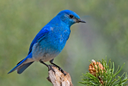

Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Class number: 2
Class name: Bird


In [71]:
from PIL import Image
import numpy as np

from IPython.display import display

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/pictures/bird.jpg')
im.thumbnail((128, 128), Image.ANTIALIAS)
display(im)

class_out=hw_classifier.classify_image(im)
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(hw_classifier.class_name(class_out)))


The detailed classification mode also gives out the classification confidence of each class.
The ranking returned here is numpy.ndarray of size (10,)

In [72]:
belief_class = hw_classifier.classify_image_details(im)
print("{: >10}{: >13}".format("[CLASS]","[RANKING]"))
for i in range(len(belief_class)):
    print("{: >10}{: >10}".format(hw_classifier.classes[i],belief_class[i]))

Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
   [CLASS]    [RANKING]
  Airplane       254
Automobile       155
      Bird       415
       Cat       279
      Deer       281
       Dog       264
      Frog       265
     Horse       250
      Ship       261
     Truck       136


## 5. Get pixels sensitive to prediction confidence

There are three hyperparameters here in the attack settings:
1. Step.   The sampling stride for choosing pixels, for examples, step=2 means choose pixels every x=x+2 or y=y+2;
2. Thres.  A threshold value for choosing sensitive pixels among sampled pixels;
3. Lamda.  The magnitude of perturbation added to the original image.

The code below shows the process of modify one pixel at a time and get classification confidence values. Here just use the classifier once per image, but later in the combined version, the inference on multiuple classification function would be used, that would be much faster.

In [73]:
#print(im.size)
row,col= im.size

step=2
count=0


for i in range(0,row,step):
    for j in range(0,col,step):
        count= count+1
#modarr=np.zeros((count,10))

clsarr=np.zeros((count,10))

count=0
for i in range(0,row,step):
    for j in range(0,col,step):
        imtst= im.copy()
        imdat= imtst.load()
        imR,imG,imB = imdat[i,j]
        imdat[i,j] = (imR+30,imG+60,imB+10) #3,6,1
        mod_class = hw_classifier.classify_image_details(imtst)
        #display(imtst)
        
        clsarr[ count, ]= mod_class
        count=count+1



Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 5

Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 5

## 6. Get sensitive pixels and get their signs

One important point here is that how to define sensitive pixels?

A metric is required to do this measurement.
As mentioned, the classifier returns an array containing prediction confidence for each class and the class with the highest confidence would be the classification result.
Normally, the standard metric used in deep learning is the crossentropy. To further reduce the computation burden, just use the confidence difference between the largest and second largest as the prediction robustness metric. Set a threshold value to filter out very small changes and the rest would be regarded as sensitive pixels need to be modified.

Here learning from the classic FGSM(Fast Gradient Sign Method) method, get the sign of these pixel changes.

In [74]:
## Max- 2ndMax Condifence Decrease
thres = 2

#print(belief_class)
beliefdif= np.max(belief_class)- np.min( belief_class[np.argpartition(belief_class, -2)[-2:]] )
#belief_class[class_out]- np.max(belief_class[0:class_out:])
#print(beliefdif)
        
class_out=belief_class.argmax(axis=0)
#class_out=int(class_max)
    
modout= clsarr[:,class_out]
#print(type(class_out))
#print(modout.shape)
ind=range(clsarr.shape[1])
ind=np.setdiff1d(ind,class_out)
#print(modout)
#print(np.max( clsarr[:,ind],axis=1 ))
modout= modout- np.max( clsarr[:,ind],axis=1 )-beliefdif

#print(modout)
    
modsign= modout.copy()
#thres = 2
modsign[np.abs(modsign) <= thres] = 0 
modsign= np.sign(modsign)
print('Sign of sensitive pixels:')
print(modsign)


Sign of sensitive pixels:
[-1. -1.  0. -1.  1.  1.  0. -1. -1.  0. -1.  0.  0. -1.  1.  1.  0.  0.
 -1.  1.  0.  1.  1.  0.  0. -1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1.
 -1. -1. -1. -1.  0. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1.  1. -1. -1.
 -1.  1. -1. -1. -1. -1. -1.  1.  0.  0. -1.  0.  0.  0. -1. -1. -1.  1.
 -1. -1. -1.  0. -1.  0.  0. -1.  1.  0. -1. -1.  0. -1. -1.  0. -1. -1.
  0.  0.  0. -1. -1. -1. -1. -1. -1.  0. -1.  0.  0. -1. -1. -1. -1. -1.
 -1.  0.  1.  0.  0. -1. -1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  0.  0. -1. -1. -1. -1. -1.  1.  0.  0. -1.  1.
 -1. -1.  0. -1.  1. -1. -1.  0. -1. -1.  0.  1. -1.  0. -1. -1.  0.  0.
 -1.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  1. -1.  0.]


## 7. Use computed sign matrix to modify image

Use the lamda value and the sign to add to the original image.

In [75]:
lamda=2

count=int(0)
imtst= im.copy()
imdat= imtst.load()

for i in range(0,row,step):
    for j in range(0,col,step):      
        imR,imG,imB = imdat[i,j]
        sign= modsign[count]
        dif = int(-sign*lamda)
        imdat[i,j] = (imR+3*dif,imG+6*dif,imB+dif) #3,6,1
        #mod_class = hw_classifier.classify_image_details(imtst)
        #display(imtst)
        #modarr[ count, ]= mod_class - air_class
        count=count+1

## 8. Make predictions on the modified image

Now the MAGIC!

First we visualize both the original and the modified image. We can see that they have some little differences but do not affect our human's recognition on the image as a bird. 

However, the classifier classifies the modified bird image as a cat!

Original Image:


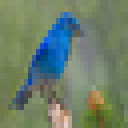

Modified Image:


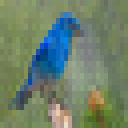

Perturbation Added:


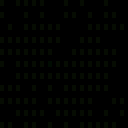

In [76]:
size=128,128
print('Original Image:')
display(im.resize(size))
print('Modified Image:')
display(imtst.resize(size))

from PIL import ImageChops
print('Perturbation Added:')
noise= ImageChops.difference(imtst, im)
display(noise.resize(size))

In [77]:
#display(imtst)
mod_out=hw_classifier.classify_image(imtst)
print("Modified image classication result: {0}".format(mod_out))
print("Modified image class name output: {0}".format(hw_classifier.class_name(mod_out)))
#mod_class = hw_classifier.classify_image_details(imtst)
#mod_class

Inference took 528.00 microseconds
Classification rate: 1893.94 images per second
Modified image classication result: 3
Modified image class name output: Cat


In [78]:
#display(im)
#class_out=hw_classifier.classify_image(im)
print("Original image class number: {0}".format(class_out))
print("Original image class name: {0}".format(hw_classifier.class_name(class_out)))
#ori_class = hw_classifier.classify_image_details(im)
#ori_class

Original image class number: 2
Original image class name: Bird


## 9. Time performance comparison
Now combine the pixel iteration and modification into one whole function and we can calculate the time usage as a performance metric.In order to make a comparison between hardware and software executions, two functions using PL and pure PS are provided.

In [79]:
def imgAdvHW(im,thres,lamda,step):
    row,col= im.size
    belief_class = hw_classifier.classify_image_details(im)
    
    #step=2
    count=0
    count1=0

    for i in range(0,row,step):
        count1=count1+1
        for j in range(0,col,step):
            count= count+1
    modarr=np.zeros((count,10))
    clsarr=np.zeros((count,10))

    modset= []

    #count=0
    for i in range(0,row,step):
        for j in range(0,col,step):
            imtst= im.copy()
            imdat= imtst.load()
            imR,imG,imB = imdat[i,j]
            imdat[i,j] = (imR+30,imG+60,imB+10) #3,6,1
            #mod_class = hw_classifier.classify_image_details(imtst)
            #display(imtst)
            modset.append(imtst)
            #modarr[ count, ]= mod_class - air_class
            #count=count+1
    #print(len(modset))
    clsarr = hw_classifier.classify_images_details(modset)
    clsarr = clsarr.reshape([len(modset),10])
    modarr = clsarr.copy()
    modarr = modarr - np.tile(belief_class,(len(modset),1))
    #print(modarr)
    #print(modarr.shape)
    
    
    '''
    ## Max Confidence Decrease
    modout= modarr[:,class_out]
    #print(modout)
    modsign= modout.copy()
    #thres = 2
    modsign[np.abs(modsign) <= thres] = 0 
    #modsign[modsign>thres]= 1
    #modsign[modsign<-thres]=-1
    modsign= np.sign(modsign)
    '''
    
    ## Max- 2ndMax Condifence Decrease
    # max confidence value minus second max confidence value
    beliefdif= np.max(belief_class)- np.min( belief_class[np.argpartition(belief_class, -2)[-2:]] )
    # get 
    class_out=belief_class.argmax(axis=0)
    #class_out=int(class_max)

    modout= clsarr[:,class_out]
    #print(type(class_out))
    #print(modout.shape)
    ind=range(clsarr.shape[1])
    ind=np.setdiff1d(ind,class_out)
    #print(modout)
    #print(np.max( clsarr[:,ind],axis=1 ))
    modout= modout- np.max( clsarr[:,ind],axis=1 )-beliefdif
    
    modsign= modout.copy()
    #thres = 2
    modsign[np.abs(modsign) <= thres] = 0 
    modsign= np.sign(modsign)
    #print(modsign)
    
    count=int(0)
    imtst= im.copy()
    imdat= imtst.load()
    #lamda=2
    for i in range(0,row,step):
        for j in range(0,col,step):      
            imR,imG,imB = imdat[i,j]
            sign= modsign[count]
            dif = int(-sign*lamda)
            imdat[i,j] = (imR+3*dif,imG+6*dif,imB+dif) #3,6,1
            #mod_class = hw_classifier.classify_image_details(imtst)
            #display(imtst)
            #modarr[ count, ]= mod_class - air_class
            count=count+1
    
    #display(im)
    #display(imtst)
    
    return imtst

In [80]:
start=time()
imtst= imgAdvHW(im,thres,lamda,step)
end = time()
hw_t = end-start
print('Hardware adversarial attack time length: ',hw_t,'s')

Inference took 527.00 microseconds
Classification rate: 1897.53 images per second
Inference took 19854.00 microseconds, 112.81 usec per image
Classification rate: 8864.71 images per second
Hardware adversarial attack time length:  0.2858085632324219 s


In [81]:
def imgAdvSW(im,thres,lamda,step):
    row,col= im.size
    belief_class = sw_classifier.classify_image_details(im)
    
    #step=2
    count=0
    count1=0

    for i in range(0,row,step):
        count1=count1+1
        for j in range(0,col,step):
            count= count+1
    modarr=np.zeros((count,10))
    clsarr=np.zeros((count,10))

    modset= []

    #count=0
    for i in range(0,row,step):
        for j in range(0,col,step):
            imtst= im.copy()
            imdat= imtst.load()
            imR,imG,imB = imdat[i,j]
            imdat[i,j] = (imR+30,imG+60,imB+10) #3,6,1
            #mod_class = hw_classifier.classify_image_details(imtst)
            #display(imtst)
            modset.append(imtst)
            #modarr[ count, ]= mod_class - air_class
            #count=count+1
    #print(len(modset))
    clsarr = sw_classifier.classify_images_details(modset)
    clsarr = clsarr.reshape([len(modset),10])
    modarr = clsarr.copy()
    modarr = modarr - np.tile(belief_class,(len(modset),1))
    #print(modarr)
    #print(modarr.shape)
    
    
    '''
    ## Max Confidence Decrease
    modout= modarr[:,class_out]
    #print(modout)
    modsign= modout.copy()
    #thres = 2
    modsign[np.abs(modsign) <= thres] = 0 
    #modsign[modsign>thres]= 1
    #modsign[modsign<-thres]=-1
    modsign= np.sign(modsign)
    '''
    
    ## Max- 2ndMax Condifence Decrease
    # max confidence value minus second max confidence value
    beliefdif= np.max(belief_class)- np.min( belief_class[np.argpartition(belief_class, -2)[-2:]] )
    # get 
    class_out=belief_class.argmax(axis=0)
    #class_out=int(class_max)

    modout= clsarr[:,class_out]
    #print(type(class_out))
    #print(modout.shape)
    ind=range(clsarr.shape[1])
    ind=np.setdiff1d(ind,class_out)
    #print(modout)
    #print(np.max( clsarr[:,ind],axis=1 ))
    modout= modout- np.max( clsarr[:,ind],axis=1 )-beliefdif
    
    modsign= modout.copy()
    #thres = 2
    modsign[np.abs(modsign) <= thres] = 0 
    modsign= np.sign(modsign)
    #print(modsign)
    
    count=int(0)
    imtst= im.copy()
    imdat= imtst.load()
    #lamda=2
    for i in range(0,row,step):
        for j in range(0,col,step):      
            imR,imG,imB = imdat[i,j]
            sign= modsign[count]
            dif = int(-sign*lamda)
            imdat[i,j] = (imR+3*dif,imG+6*dif,imB+dif) #3,6,1
            #mod_class = hw_classifier.classify_image_details(imtst)
            #display(imtst)
            #modarr[ count, ]= mod_class - air_class
            count=count+1
    
    #display(im)
    #display(imtst)
    
    return imtst

In [82]:
start=time()
imtst= imgAdvSW(im,thres,lamda,step)
end = time()
sw_t = end-start
print('Software adversarial attack time length: ',sw_t,'s')

Inference took 416661.00 microseconds
Classification rate: 2.40 images per second
Inference took 73228287.00 microseconds, 416069.81 usec per image
Classification rate: 2.40 images per second
Software adversarial attack time length:  73.91520619392395 s


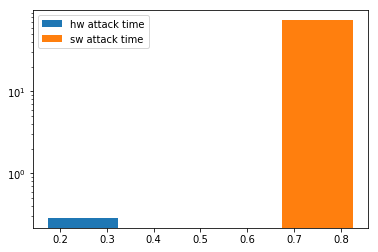

In [83]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

hw_time = [hw_t]
sw_time = [sw_t]

x_axis = ('Attack Time')

y_pos = 0.5
plt.bar(y_pos-0.25, hw_time, 0.15)
plt.bar(y_pos+0.25, sw_time, 0.15)
#plt.xticks(y_pos, x_axis)
plt.legend(["hw attack time","sw attack time"])
plt.semilogy()
plt.show()

## Conclusion

We can see that hardware attack on one image takes only 0.278s while software attack takes 73.93s. The hardware execution shows a 266x performance acceleration over software excution. Another thing worth noticing is that as hardware attack only takes 0.278s it can lead to more than 30 attacks per second which can be regarded as almost real-time in many application cases.